# 6. Model the Solution

> "All models are wrong, Some of them are useful"

### Preprocessing to get the tidy dataframe

In [1]:
# Import the library we need, which is Pandas and Matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

In [2]:
# Set some parameters to get good visuals - style to ggplot and size to 15,10
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
# Read the csv file of Monthwise Quantity and Price csv file we have.
df = pd.read_csv('MonthWiseMarketArrivals_clean.csv')

In [4]:
# Changing the date column to a Time Interval columnn
df.date = pd.DatetimeIndex(df.date)

In [5]:
# Change the index to the date column
df.index = pd.PeriodIndex(df.date, freq='M')

In [6]:
# Sort the data frame by date
df = df.sort_values(by = "date")

In [7]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MH,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MH,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MH,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MH,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MH,LASALGAON,1996-05-01


## Question 3: Can we forecast the price of Onion in Bangalore?

Get the priceMod for Bangalore Market

In [8]:
dfBang = df.loc[df.city == "BANGALORE"].copy()

In [9]:
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KT,BANGALORE,2004-01-01
2004-02,BANGALORE,February,2004,225133,741,870,793,KT,BANGALORE,2004-02-01
2004-03,BANGALORE,March,2004,221952,527,586,556,KT,BANGALORE,2004-03-01
2004-04,BANGALORE,April,2004,185150,419,518,465,KT,BANGALORE,2004-04-01
2004-05,BANGALORE,May,2004,137390,400,516,455,KT,BANGALORE,2004-05-01


In [10]:
# Drop redundant columns
dfBang = dfBang.drop(["market", "month", "year", "state", "city", "priceMin", "priceMax"], axis = 1)

In [11]:
dfBang.head()

,quantity,priceMod,date
date,,,
2004-01,227832,991,2004-01-01
2004-02,225133,793,2004-02-01
2004-03,221952,556,2004-03-01
2004-04,185150,465,2004-04-01
2004-05,137390,455,2004-05-01


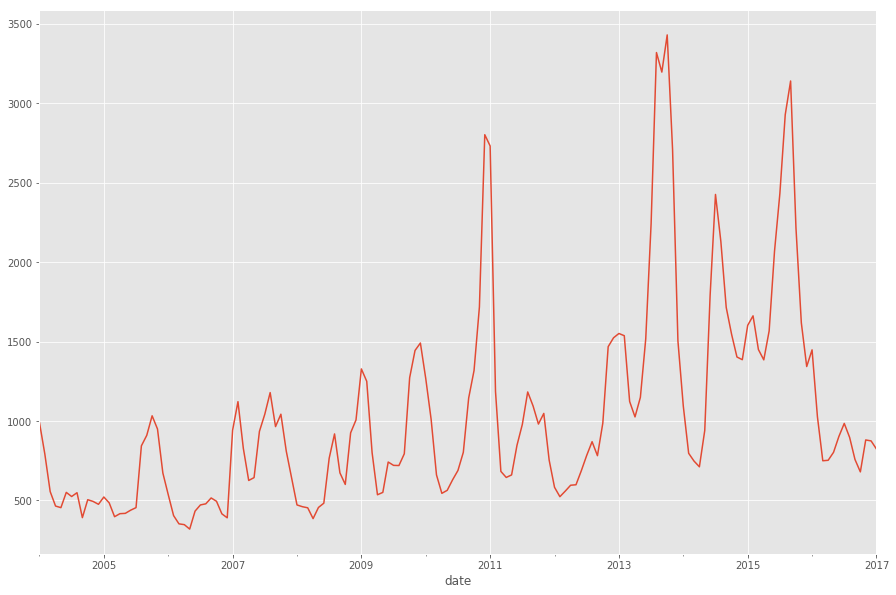

In [12]:
dfBang.priceMod.plot()

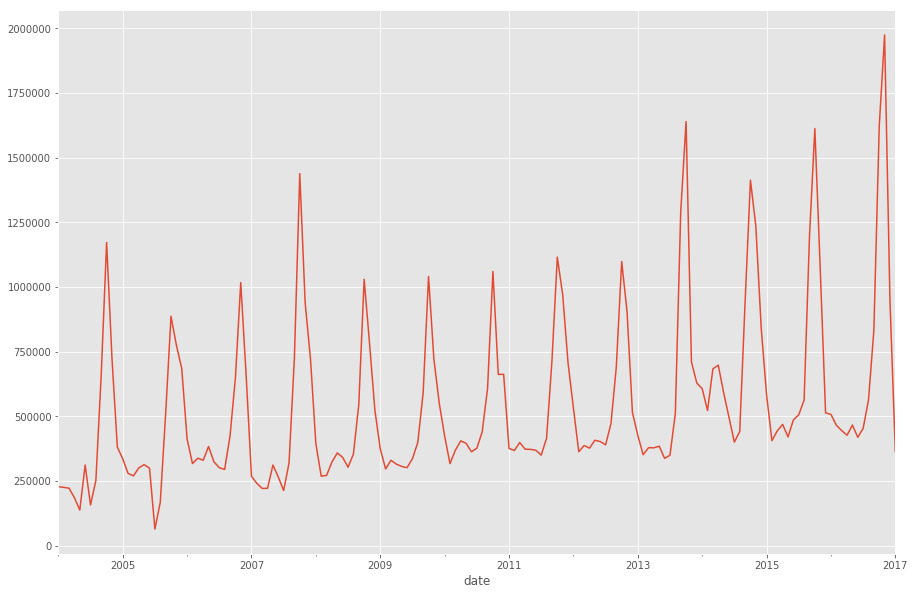

In [13]:
dfBang.quantity.plot()

### Transformation - Log

Transformations such as logarithms can help to stabilize the variance of a time series. 


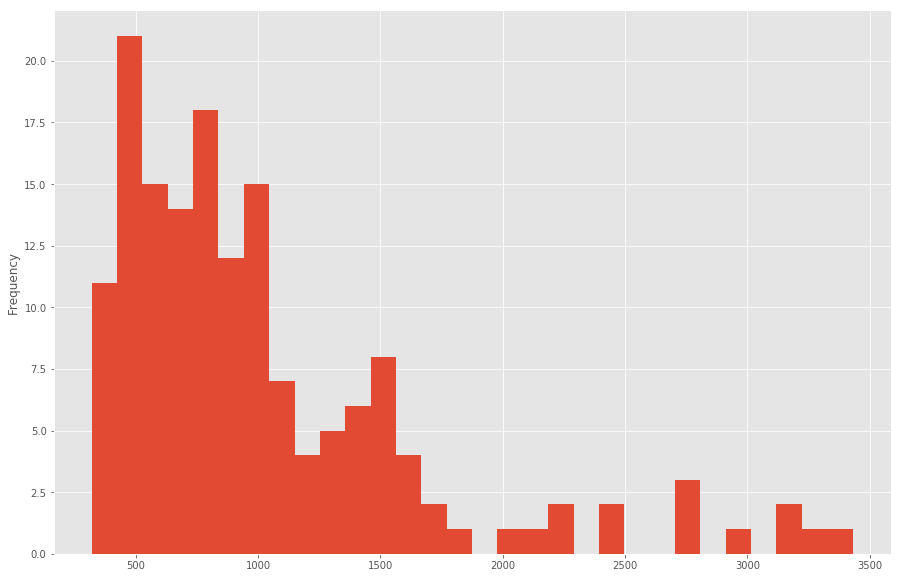

In [14]:
dfBang.priceMod.plot(kind = "hist", bins = 30)

In [15]:
dfBang['priceModLog'] = np.log(dfBang.priceMod)
dfBang.head()

,quantity,priceMod,date,priceModLog
date,,,,
2004-01,227832,991,2004-01-01,6.898715
2004-02,225133,793,2004-02-01,6.675823
2004-03,221952,556,2004-03-01,6.320768
2004-04,185150,465,2004-04-01,6.142037
2004-05,137390,455,2004-05-01,6.120297


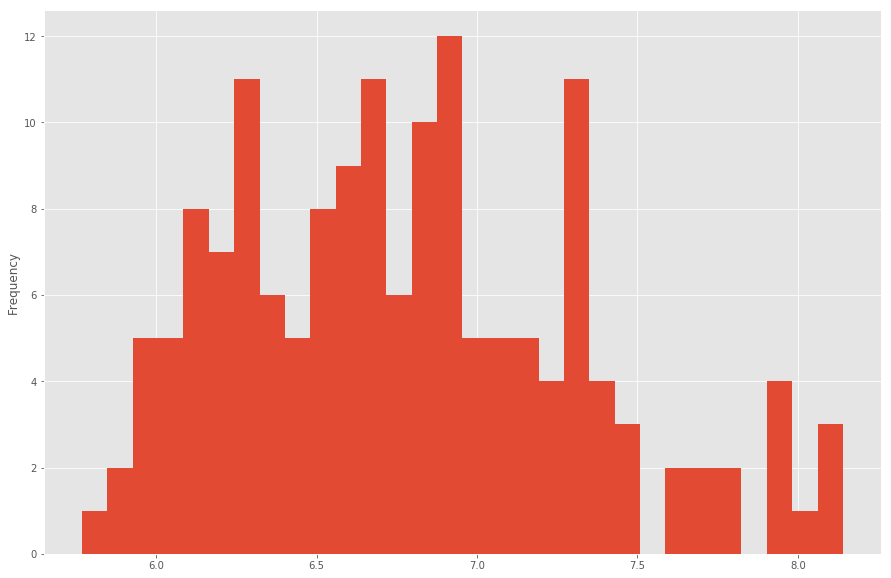

In [16]:
dfBang.priceModLog.plot(kind = "hist", bins = 30)

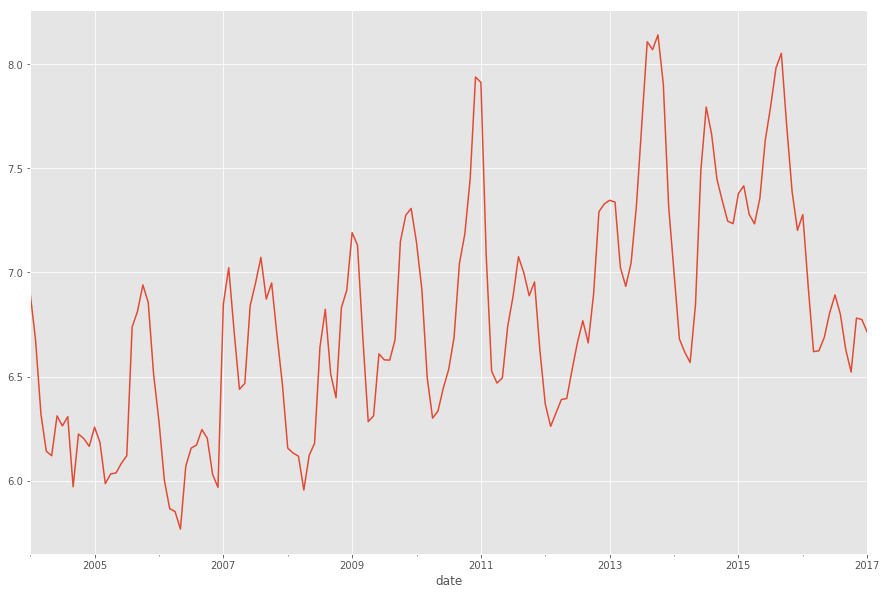

In [17]:
dfBang.priceModLog.plot()

## Basic Time Series Model

We will build a time-series forecasting model to get a forecast for Onion prices. Let us start with the three most basic models - 
1. Mean Constant Model
2. Linear Trend Model
3. Random Walk Model

## Mean  Model

This very simple forecasting model will be called the "mean model"

In [18]:
model_mean_pred = dfBang.priceModLog.mean()

In [19]:
# Let us store this as our Mean Predication Value
dfBang["priceMean"] = np.exp(model_mean_pred)

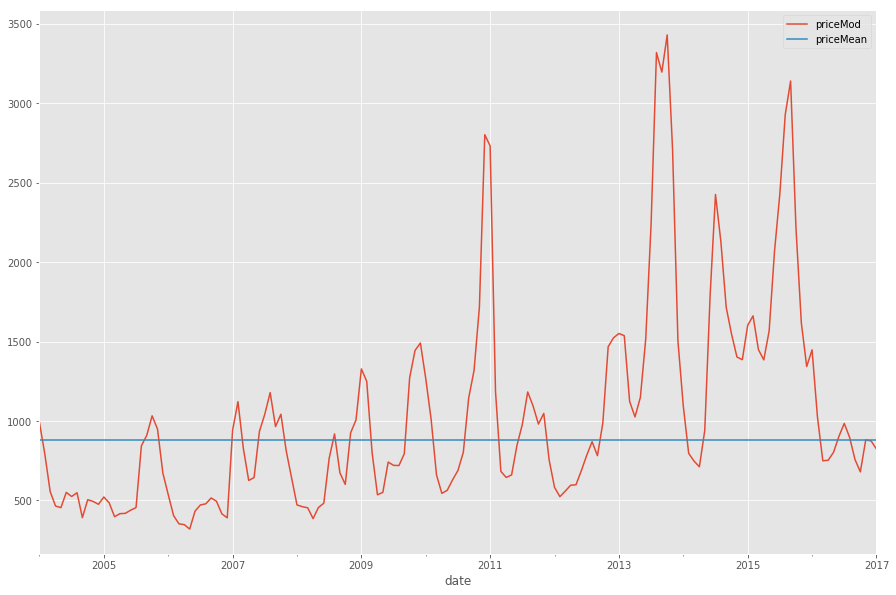

In [20]:
dfBang.plot(kind="line", x="date", y = ["priceMod", "priceMean"])

**Can we measure the error rate?**

We will use Root Mean Squared Error (RMSE) to calculate our error values

$RMSE = \Sigma \sqrt{ (\hat{y} - y)^2/n} $ , where $\hat{y}$ is  predicted value of y

In [21]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [22]:
model_mean_RMSE = RMSE(dfBang.priceMean, dfBang.priceMod)
model_mean_RMSE

661.04032439783873

In [23]:
# Save this in a dataframe
dfBangResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
dfBangResults.head()

,Model,Forecast,RMSE


In [24]:
dfBangResults.loc[0,"Model"] = "Mean"
dfBangResults.loc[0,"Forecast"] = np.exp(model_mean_pred)
dfBangResults.loc[0,"RMSE"] = model_mean_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,879.77,661.04


## Linear Trend Model

Let us start by plotting a linear trend model between priceModLog and time.

However to do linear regression, we need a numeric indicator for time period - Let us create that.

In [25]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean
date,,,,,
2004-01,227832,991,2004-01-01,6.898715,879.77008
2004-02,225133,793,2004-02-01,6.675823,879.77008
2004-03,221952,556,2004-03-01,6.320768,879.77008
2004-04,185150,465,2004-04-01,6.142037,879.77008
2004-05,137390,455,2004-05-01,6.120297,879.77008


In [26]:
dfBang.dtypes

quantity                int64
priceMod                int64
date           datetime64[ns]
priceModLog           float64
priceMean             float64
dtype: object

In [27]:
# What is the starting month of our data
dfBang.date.min()

Timestamp('2004-01-01 00:00:00')

In [28]:
# Convert date in datetimedelta figure starting from zero
dfBang["timeIndex"] = dfBang.date - dfBang.date.min()

In [29]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex
date,,,,,,
2004-01,227832,991,2004-01-01,6.898715,879.77008,0 days
2004-02,225133,793,2004-02-01,6.675823,879.77008,31 days
2004-03,221952,556,2004-03-01,6.320768,879.77008,60 days
2004-04,185150,465,2004-04-01,6.142037,879.77008,91 days
2004-05,137390,455,2004-05-01,6.120297,879.77008,121 days


In [30]:
dfBang.dtypes

quantity                 int64
priceMod                 int64
date            datetime64[ns]
priceModLog            float64
priceMean              float64
timeIndex      timedelta64[ns]
dtype: object

In [31]:
# Convert to months using the timedelta function
dfBang["timeIndex"] =  dfBang["timeIndex"]/np.timedelta64(1, 'M')

In [32]:
dfBang.timeIndex.head()

date
2004-01    0.000000
2004-02    1.018501
2004-03    1.971293
2004-04    2.989794
2004-05    3.975441
Freq: M, Name: timeIndex, dtype: float64

In [33]:
# Round the number to 0
dfBang["timeIndex"] = dfBang["timeIndex"].round(0).astype(int)

In [34]:
dfBang.timeIndex.tail()

date
2016-09    152
2016-10    153
2016-11    154
2016-12    155
2017-01    156
Freq: M, Name: timeIndex, dtype: int64

In [35]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex
date,,,,,,
2004-01,227832,991,2004-01-01,6.898715,879.77008,0
2004-02,225133,793,2004-02-01,6.675823,879.77008,1
2004-03,221952,556,2004-03-01,6.320768,879.77008,2
2004-04,185150,465,2004-04-01,6.142037,879.77008,3
2004-05,137390,455,2004-05-01,6.120297,879.77008,4


In [36]:
## Now plot linear regression between priceMod and timeIndex
model_linear = smf.ols('priceModLog ~ timeIndex', data = dfBang).fit()

In [37]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     93.00
Date:                Fri, 20 Jan 2017   Prob (F-statistic):           1.57e-17
Time:                        22:44:46   Log-Likelihood:                -88.669
No. Observations:                 157   AIC:                             181.3
Df Residuals:                     155   BIC:                             187.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.2122      0.068     91.289      0.000         6.078     6.347
timeIndex      0.0073      0.001      9.644      0.000         0.006     0.009
==============================================================================
Omnibus:                        6.193   Durbin-Watson:                   0.321
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.235
Skew:                           0.454   Prob(JB):                       0.0443
Kurtosis:                       2.642   Cond. No.                         180.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
## Parameters for y = mx + c equation
model_linear.params

Intercept    6.212238
timeIndex    0.007275
dtype: float64

In [39]:
c = model_linear.params[0]
c

6.2122383469798645

In [40]:
m = model_linear.params[1]
m

0.0072746442825617069

In [41]:
model_linear_pred = model_linear.predict()

In [42]:
model_linear_pred

array([ 6.21223835,  6.21951299,  6.22678764,  6.23406228,  6.24133692,
        6.24861157,  6.25588621,  6.26316086,  6.2704355 ,  6.27771015,
        6.28498479,  6.29225943,  6.29953408,  6.30680872,  6.31408337,
        6.32135801,  6.32863266,  6.3359073 ,  6.34318194,  6.35045659,
        6.35773123,  6.36500588,  6.37228052,  6.37955517,  6.38682981,
        6.39410445,  6.4013791 ,  6.40865374,  6.41592839,  6.42320303,
        6.43047768,  6.43775232,  6.44502696,  6.45230161,  6.45957625,
        6.4668509 ,  6.47412554,  6.48140019,  6.48867483,  6.49594947,
        6.50322412,  6.51049876,  6.51777341,  6.52504805,  6.5323227 ,
        6.53959734,  6.54687198,  6.55414663,  6.56142127,  6.56869592,
        6.57597056,  6.58324521,  6.59051985,  6.59779449,  6.60506914,
        6.61234378,  6.61961843,  6.62689307,  6.63416772,  6.64144236,
        6.648717  ,  6.65599165,  6.66326629,  6.67054094,  6.67781558,
        6.68509023,  6.69236487,  6.69963951,  6.70691416,  6.71

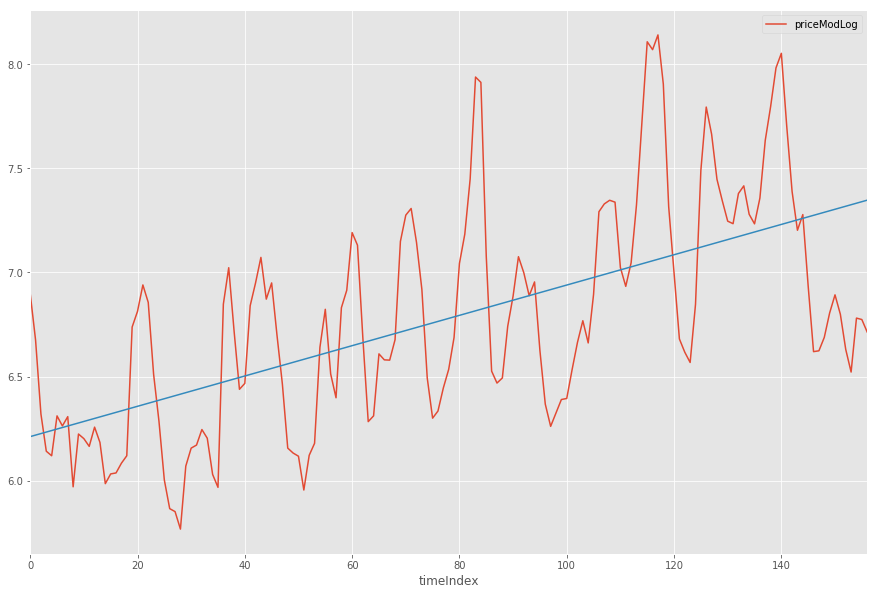

In [43]:
# Plot the prediction line
dfBang.plot(kind="line", x="timeIndex", y = "priceModLog")
plt.plot(dfBang.timeIndex,model_linear_pred, '-')

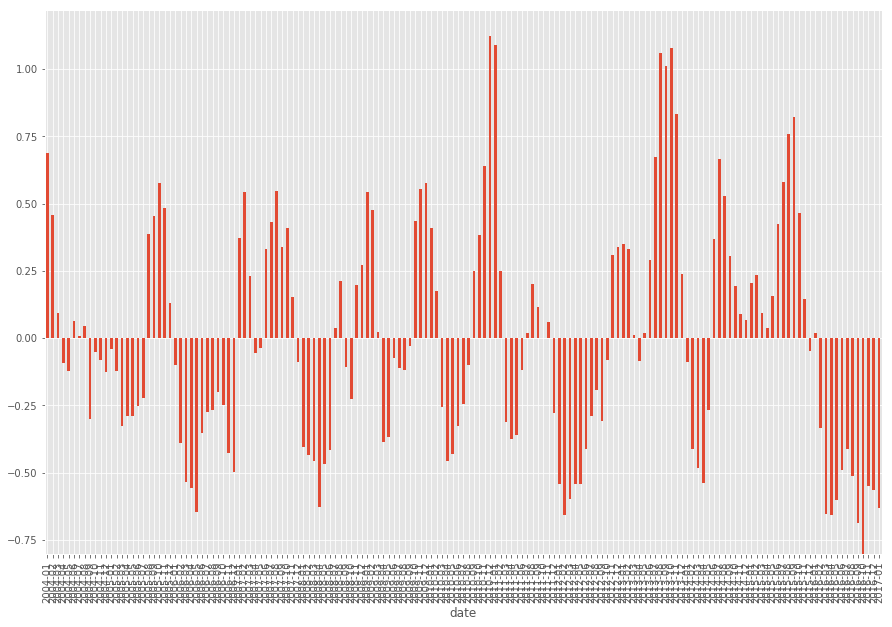

In [44]:
model_linear.resid.plot(kind = "bar")

**Is this a good model?**

What measures can we check to see if the model is good?

It is seen here (and  also evident on the regression line plot, if you look closely) that the linear trend model has a tendency to make an error of the same sign for many periods in a row. This tendency is measured in statistical terms by the **lag-1 autocorrelation and Durbin-Watson statistic**.  If there is no time pattern, the lag-1 autocorrelation should be very close to zero, and the Durbin-Watson statistic ought to be very close to 2, which is not the case here.  If the model has succeeded in extracting all the "signal" from the data, there should be no pattern at all in the errors: the error in the next period should not be correlated with any previous errors. The linear trend model obviously fails the autocorrelation test in this case.


In [45]:
# Manual Calculation
model_linear_forecast_manual = m * 146 + c
model_linear_forecast_manual

7.2743364122338736

In [46]:
# Using Predict Function
model_linear_forecast_auto = model_linear.predict(exog = dict(timeIndex=146))
model_linear_forecast_auto

array([ 7.27433641])

In [47]:
dfBang["priceLinear"] = np.exp(model_linear_pred)

In [48]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex,priceLinear
date,,,,,,,
2004-01,227832,991,2004-01-01,6.898715,879.77008,0,498.816527
2004-02,225133,793,2004-02-01,6.675823,879.77008,1,502.458471
2004-03,221952,556,2004-03-01,6.320768,879.77008,2,506.127005
2004-04,185150,465,2004-04-01,6.142037,879.77008,3,509.822324
2004-05,137390,455,2004-05-01,6.120297,879.77008,4,513.544622


In [49]:
# Root Mean Squared Error (RMSE)
model_linear_RMSE = RMSE(dfBang.priceLinear, dfBang.priceMod)
model_linear_RMSE

564.99811296128576

In [50]:
dfBangResults.loc[1,"Model"] = "Linear"
dfBangResults.loc[1,"Forecast"] = np.exp(model_linear_forecast_manual)
dfBangResults.loc[1,"RMSE"] = model_linear_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,879.77,661.04
1,Linear,1442.79,564.998


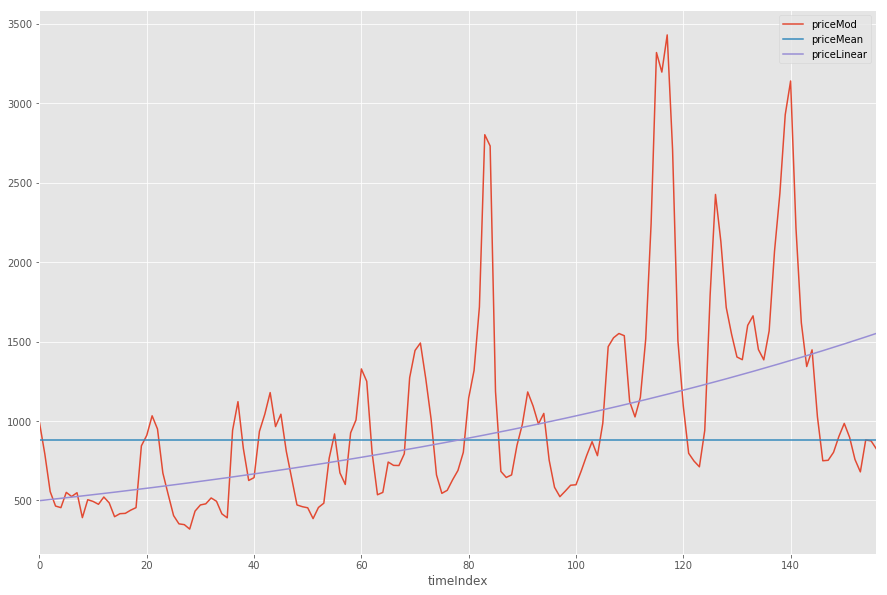

In [51]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear"])

## Linear Model with Regressor

In [52]:
## Now plot linear regression between priceMod and timeIndex
model_linear_quantity = smf.ols('priceModLog ~ timeIndex + np.log(quantity)', data = dfBang).fit()

In [53]:
model_linear_quantity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     49.61
Date:                Fri, 20 Jan 2017   Prob (F-statistic):           2.35e-17
Time:                        22:45:17   Log-Likelihood:                -86.527
No. Observations:                 157   AIC:                             179.1
Df Residuals:                     154   BIC:                             188.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            4.3537      0.903      4.821      0.000         2.570     6.138
timeIndex            0.0065      0.001      7.735      0.000         0.005     0.008
np.log(quantity)     0.1471      0.071      2.064      0.041         0.006     0.288
==============================================================================
Omnibus:                        5.380   Durbin-Watson:                   0.343
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                5.323
Skew:                           0.410   Prob(JB):                       0.0699
Kurtosis:                       2.626   Cond. No.                     2.43e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
dfBang["priceLinearQuantity"] = np.exp(model_linear_quantity.predict())

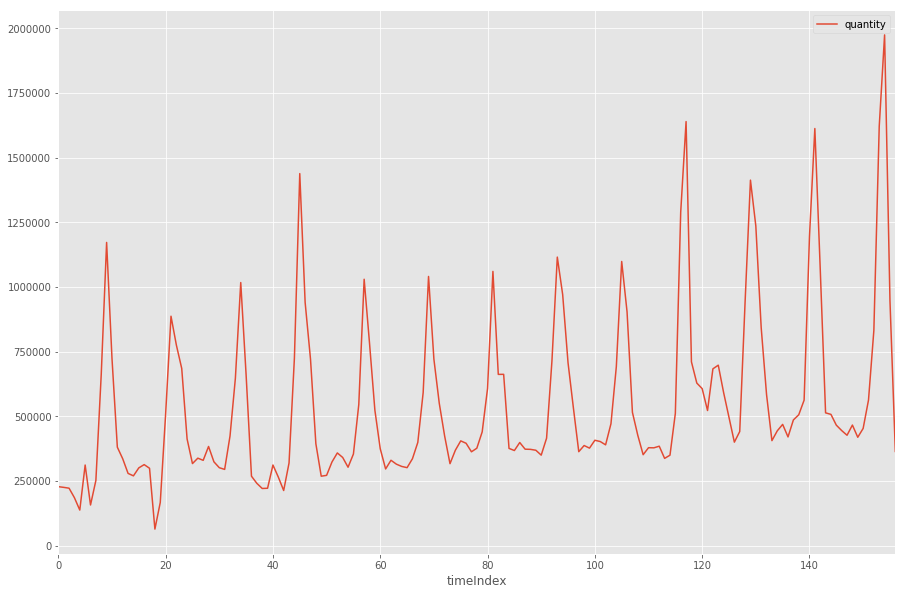

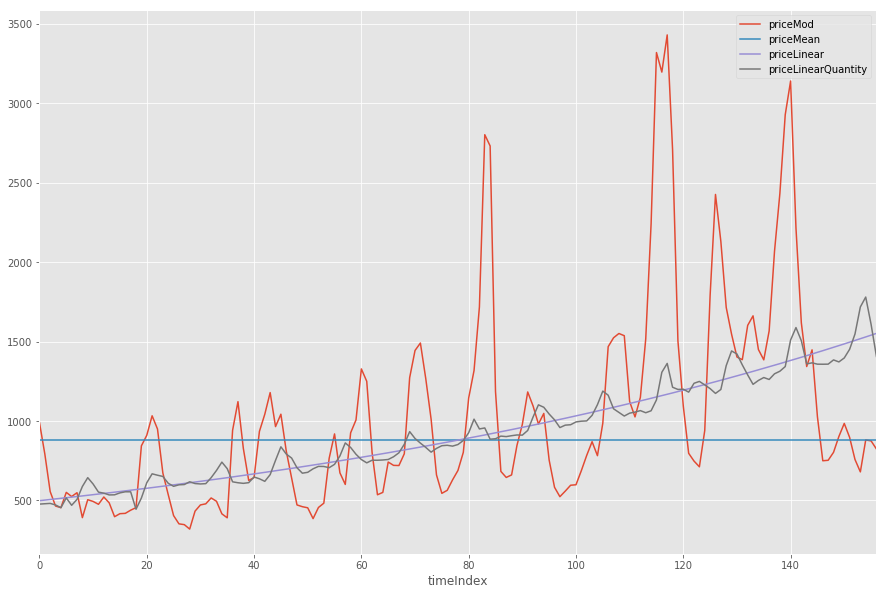

In [55]:
dfBang.plot(kind = "line", x="timeIndex", y = "quantity")
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", 
                                             "priceLinear", "priceLinearQuantity"])

## Random Walk Model

When faced with a time series that shows irregular growth, the best strategy may not be to try to directly predict the level of the series at each period (i.e., the quantity Yt). Instead, it may be better to try to predict the change that occurs from one period to the next (i.e., the quantity Yt - Yt-1). That is, it may be better to look at the first difference of the series, to see if a predictable pattern can be found there. For purposes of one-period-ahead forecasting, it is just as good to predict the next change as to predict the next level of the series, since the predicted change can be added to the current level to yield a predicted level. The simplest case of such a model is one that always predicts that the next change will be zero, as if the series is equally likely to go up or down in the next period regardless of what it has done in the past.


**Random Walk Model** $$ \hat{Y_t} = Y_{t-1} + \epsilon \\$$

**Random Walk Model with drift** $$ \hat{Y_t} = Y_{t-1} + c + \epsilon \\$$

In [56]:
dfBang["priceModLogShift1"] = dfBang.priceModLog.shift()

In [57]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1
date,,,,,,,,,
2004-01,227832,991,2004-01-01,6.898715,879.77008,0,498.816527,477.253620,NaN
2004-02,225133,793,2004-02-01,6.675823,879.77008,1,502.458471,479.518099,6.898715
2004-03,221952,556,2004-03-01,6.320768,879.77008,2,506.127005,481.629448,6.675823
2004-04,185150,465,2004-04-01,6.142037,879.77008,3,509.822324,472.008583,6.320768
2004-05,137390,455,2004-05-01,6.120297,879.77008,4,513.544622,454.684748,6.142037


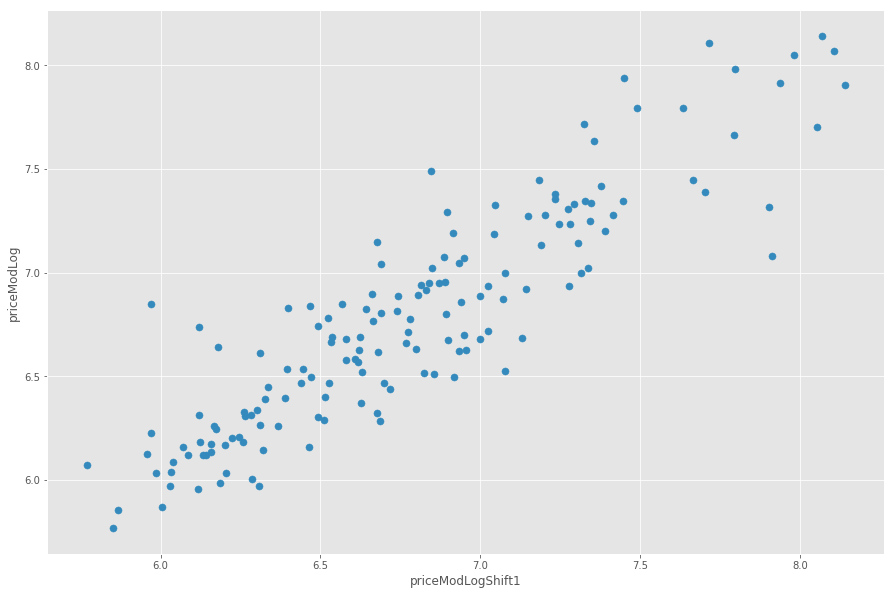

In [58]:
dfBang.plot(kind= "scatter", y = "priceModLog", x = "priceModLogShift1", s = 50)

In [59]:
# Lets plot the one-month difference curve
dfBang["priceModLogDiff"] = dfBang.priceModLog - dfBang.priceModLogShift1

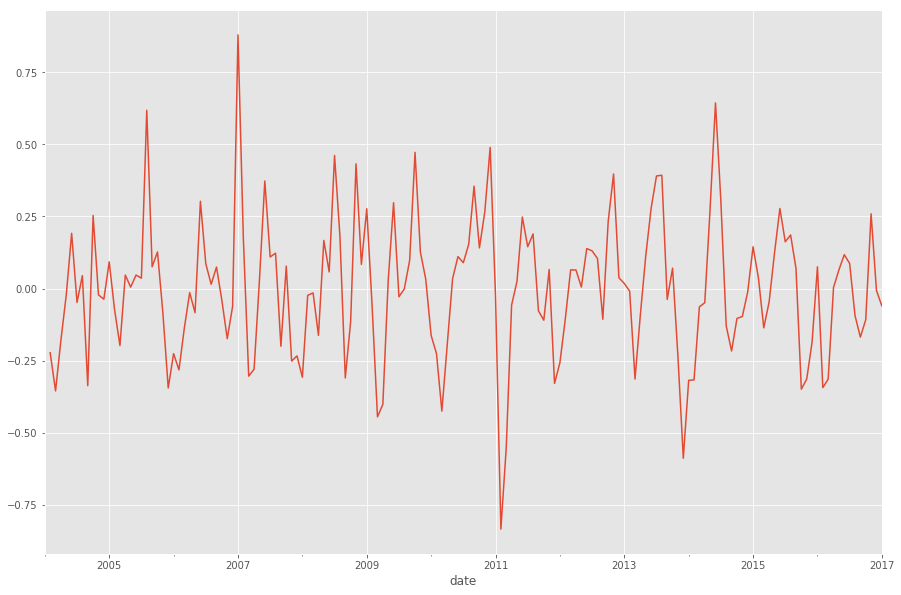

In [60]:
dfBang.priceModLogDiff.plot()

In [61]:
dfBang["priceRandom"] = np.exp(dfBang.priceModLogShift1)
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1,priceModLogDiff,priceRandom
date,,,,,,,,,,,
2004-01,227832,991,2004-01-01,6.898715,879.77008,0,498.816527,477.253620,NaN,NaN,NaN
2004-02,225133,793,2004-02-01,6.675823,879.77008,1,502.458471,479.518099,6.898715,-0.222891,991.0
2004-03,221952,556,2004-03-01,6.320768,879.77008,2,506.127005,481.629448,6.675823,-0.355055,793.0
2004-04,185150,465,2004-04-01,6.142037,879.77008,3,509.822324,472.008583,6.320768,-0.178731,556.0
2004-05,137390,455,2004-05-01,6.120297,879.77008,4,513.544622,454.684748,6.142037,-0.021740,465.0


In [62]:
dfBang.tail()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1,priceModLogDiff,priceRandom
date,,,,,,,,,,,
2016-09,831895,758,2016-09-01,6.630683,879.77008,152,1507.162884,1547.580604,6.799056,-0.168372,897.0
2016-10,1620273,680,2016-10-01,6.522093,879.77008,153,1518.166935,1718.113199,6.630683,-0.108591,758.0
2016-11,1974018,881,2016-11-01,6.781058,879.77008,154,1529.251328,1780.255979,6.522093,0.258965,680.0
2016-12,947081,875,2016-12-01,6.774224,879.77008,155,1540.416650,1608.375119,6.781058,-0.006834,881.0
2017-01,363991,824,2017-01-01,6.714171,879.77008,156,1551.663492,1406.449037,6.774224,-0.060053,875.0


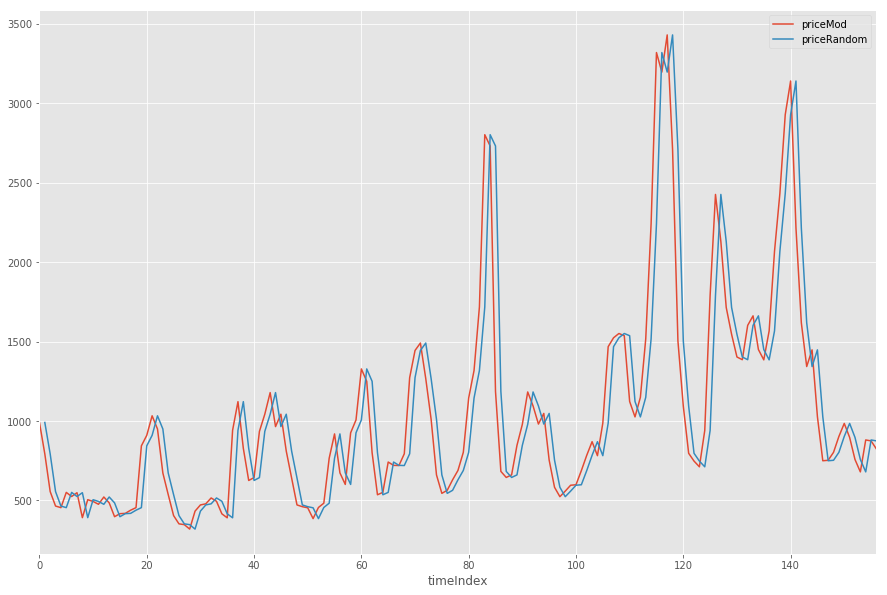

In [63]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod","priceRandom"])

In [64]:
# Root Mean Squared Error (RMSE)
model_random_RMSE = RMSE(dfBang.priceRandom, dfBang.priceMod)
model_random_RMSE

314.31883004853046

In [65]:
dfBangResults.loc[2,"Model"] = "Random"
dfBangResults.loc[2,"Forecast"] = np.exp(dfBang.priceModLogShift1[-1])
dfBangResults.loc[2,"RMSE"] = model_random_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,879.77,661.04
1,Linear,1442.79,564.998
2,Random,875,314.319


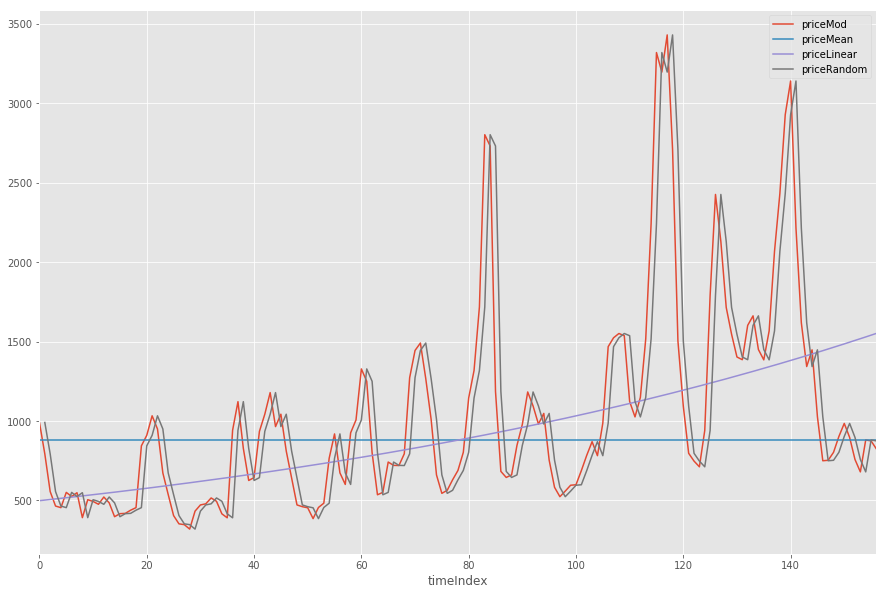

In [66]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom"])

## Advanced Model

Most of the time series models work on the assumption that the time series is stationary. Intuitively, we can see that if a time series has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series

**Statistical stationarity**: A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past! 

There are three basic criterion for a series to be classified as stationary series :

- The mean of the series should not be a function of time rather should be a constant. 

![](../img/Mean_nonstationary.png)

- The variance of the series should not a be a function of time. This property is known as homoscedasticity.

![](../img/Var_nonstationary.png)

- The covariance of the i th term and the (i + m) th term should not be a function of time.

![](../img/Cov_nonstationary.png)

### How do we check for Stationarity in a series? 

- **Plotting Rolling Statistics**: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
- **Dickey-Fuller Test**: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the time series is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

###  Augmented Dickey Fuller Test of Stationarity

The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

$$ Y_t = \rho * Y_{t-1} + \epsilon_t \\$$
$$  Y_t - Y_{t-1} = (\rho - 1) Y_{t - 1} + \epsilon_t \\$$

We have to test if p – 1 is significantly different than zero or not. If the null hypothesis gets rejected, we’ll get a stationary time series.

In [127]:
def adf(ts):
    
    # Determing rolling statistics
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()

    #Plot rolling statistics:
    ts.plot(color='blue',label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rolstd.plot(color='black', label = 'Rolling Std')

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Calculate ADF factors
    adftest = adfuller(ts, autolag='AIC')
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','# of Lags Used',
                                              'Number of Observations Used'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    return adfoutput

## How to make a Time Series Stationary?

Lets understand what is making a time series non-stationary. There are 3 major reasons behind non-stationarity:

- **Trend**: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend “changing direction” when it might go from an increasing trend to a decreasing trend.
- **Seasonal**: A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period.
- **Cyclic**: A cyclic pattern exists when data exhibit rises and falls that are not of fixed period. The duration of these fluctuations is usually of at least 2 years.

$$ y_t=S_t+T_t+E_t \\$$

where $y_t$ is the data at period `t`, $S_t$ is the seasonal component at period 't', $T_t$ is the trend-cycle component at period tt and $E_t$ is the remainder (or irregular or error) component at period tt. 

Alternatively, a multiplicative model would be written as

$$ y_t=S_t*T_t*E_t \\$$

The additive model is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative model is more appropriate. With economic time series, multiplicative models are common.

An alternative to using a multiplicative model, is to first transform the data until the variation in the series appears to be stable over time, and then use an additive model. When a log transformation has been used, this is equivalent to using a multiplicative decomposition because

$$ log y_t=log S_t+ log T_t + log E_t \\$$

Sometimes, the trend-cycle component is simply called the “trend” component, even though it may contain cyclic behaviour as well.


## Forecasting Steps 

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

## Estimating and Eliminating Trend

1. Transformation - Take a log, sqrt, cuberoot etc. transformation
2. Aggregation – taking average for a time period like monthly/weekly averages
3. Smoothing – taking rolling averages, exponential smoothing
4. Polynomial Fitting – fit a regression model

## Simple Moving Average 

As a first step in moving beyond mean models, random walk model and linear trend models, nonseasonal patterns and trends can be extrapolated using a moving-average or smoothing model. The basic assumption behind averaging and smoothing models is that the time series is locally stationary with a slowly varying mean. Hence, we take a moving (local) average to estimate the current value of the mean and then use that as the forecast for the near future. This can be considered as a compromise between the mean model and the random-walk-without-drift-model. The same strategy can be used to estimate and extrapolate a local trend.  A moving average is often called a "smoothed" version of the original series because short-term averaging has the effect of smoothing out the bumps in the original series. By adjusting the degree of smoothing (the width of the moving average), we can hope to strike some kind of optimal balance between the performance of the mean and random walk models.

Simple Moving Average (SMA)

$$ \hat{y_t} = \frac{y_{t-1} + y_{t-2} + y_{t-3} + ... + y_{t-m}}{m} \\$$

In [128]:
# For smoothing the values we can use 12 month Moving Averages 
dfBang['priceModLogMA12'] = dfBang.priceModLog.rolling(window = 12).mean()

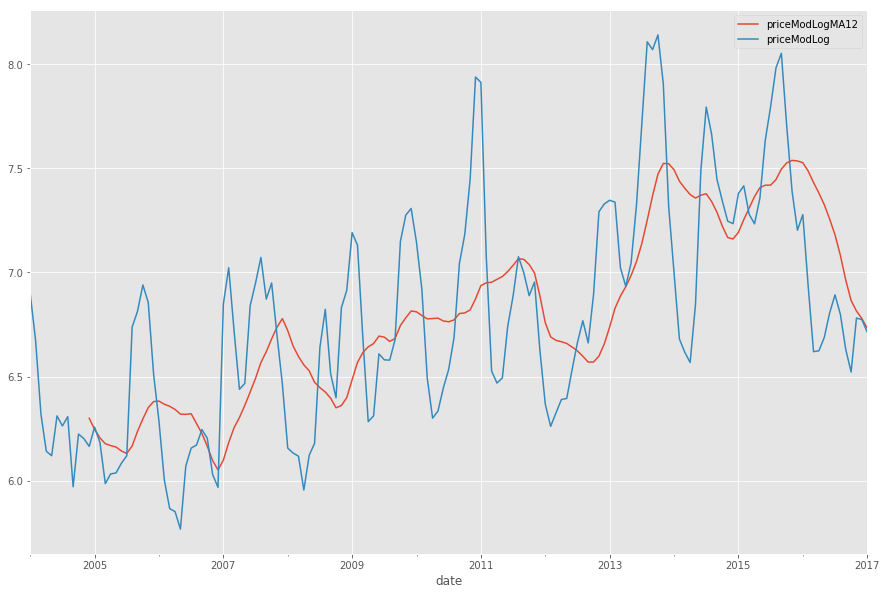

In [129]:
dfBang.plot(kind ="line", y=["priceModLogMA12", "priceModLog"])

The long-term forecasts from the SMA model are a horizontal straight line, just as in the random walk model. Thus, the SMA model assumes that there is no trend in the data. However, whereas the forecasts from the random walk model are simply equal to the last observed value, the forecasts from the SMA model are equal to a weighted average of recent values.

    

In [130]:
dfBang["priceMA12"] = np.exp(dfBang.priceModLogMA12)
dfBang.tail()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1,priceModLogDiff,priceRandom,priceModLogMA12,priceMA12,priceModLogExp12,priceExp12
date,,,,,,,,,,,,,,,
2016-09,831895,758,2016-09-01,6.630683,879.77008,152,1507.162884,1547.580604,6.799056,-0.168372,897.0,6.963962,1057.816629,7.136718,1257.295268
2016-10,1620273,680,2016-10-01,6.522093,879.77008,153,1518.166935,1718.113199,6.630683,-0.108591,758.0,6.865553,958.675559,7.102217,1214.657091
2016-11,1974018,881,2016-11-01,6.781058,879.77008,154,1529.251328,1780.255979,6.522093,0.258965,680.0,6.814895,911.321125,7.084189,1192.955904
2016-12,947081,875,2016-12-01,6.774224,879.77008,155,1540.416650,1608.375119,6.781058,-0.006834,881.0,6.779192,879.358112,7.066790,1172.379009
2017-01,363991,824,2017-01-01,6.714171,879.77008,156,1551.663492,1406.449037,6.774224,-0.060053,875.0,6.732212,839.000711,7.046997,1149.401897


In [131]:
model_MA12_forecast = dfBang.priceModLog.tail(12).mean()

In [132]:
# Root Mean Squared Error (RMSE)
model_MA12_RMSE = RMSE(dfBang.priceMA12, dfBang.priceMod)
model_MA12_RMSE

518.02068372622466

In [133]:
dfBangResults.loc[3,"Model"] = "Moving Average 12"
dfBangResults.loc[3,"Forecast"] = np.exp(model_MA12_forecast)
dfBangResults.loc[3,"RMSE"] = model_MA12_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,879.77,661.04
1,Linear,1442.79,564.998
2,Random,875,314.319
3,Moving Average 12,839.001,518.021
4,Exp Smoothing 12,1128.13,543.605


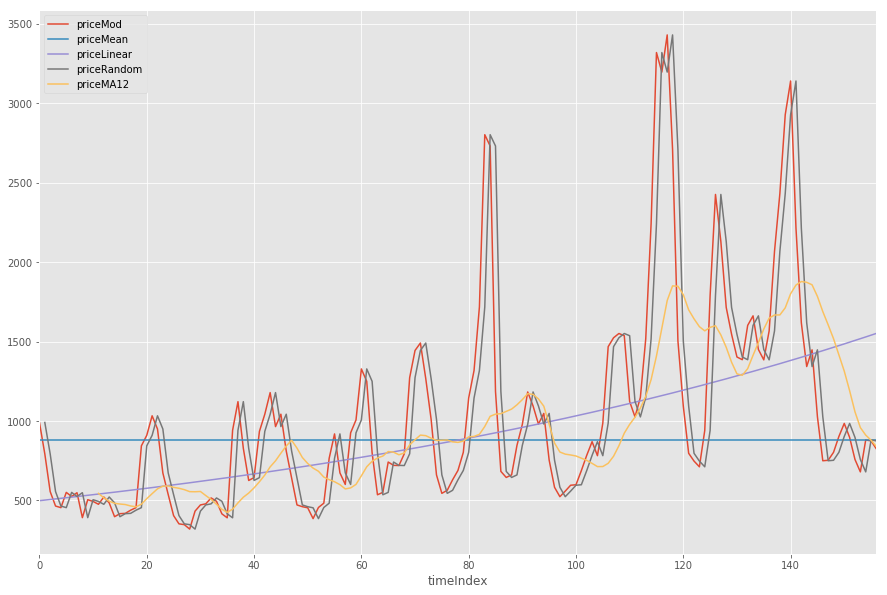

In [134]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear",
                                             "priceRandom", "priceMA12"])

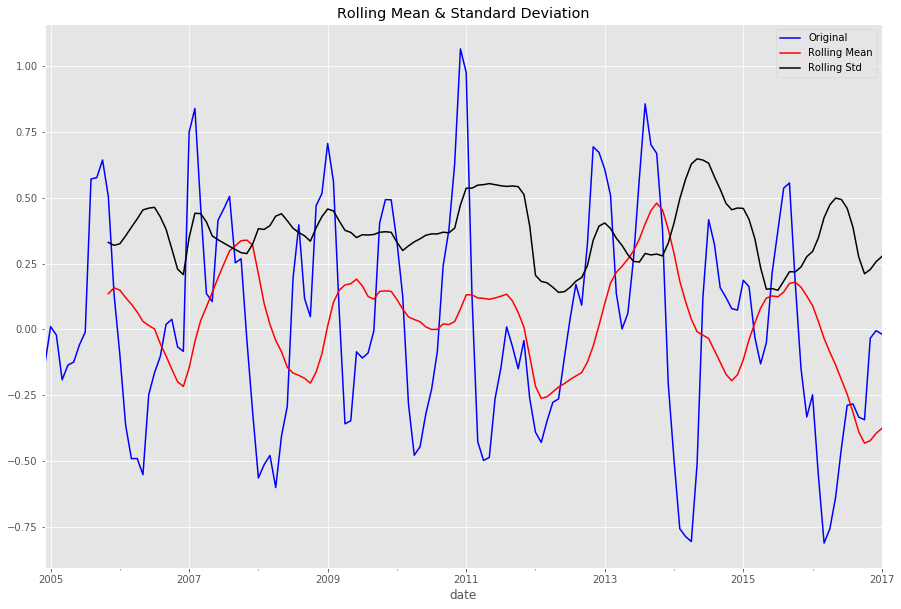

Test Statistic                -6.539898e+00
p-value                        9.403825e-09
# of Lags Used                 1.000000e+00
Number of Observations Used    1.440000e+02
Critical Value (10%)          -2.577589e+00
Critical Value (5%)           -2.881829e+00
Critical Value (1%)           -3.476598e+00
dtype: float64

In [135]:
# Test remaining part for Stationary
ts = dfBang.priceModLog - dfBang.priceModLogMA12
ts.dropna(inplace = True)
adf(ts)


## Simple Exponential Smoothing Model (SES)

Instead of equally weighting each of the observation, in the SES model we give more weightage to the recent observations and less to the older ones. This is done by the using a smoothing variable like alpha

$$ \hat{y_t} = \alpha y_{t-1} + (1-\alpha)\hat{y_{t-1}} \\$$

In [136]:
dfBang['priceModLogExp12'] = pd.ewma(dfBang.priceModLog, halflife=12)

/Users/amitkaps/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,halflife=12,adjust=True,ignore_na=False).mean()
  if __name__ == '__main__':


In [137]:
halflife = 12
alpha = 1 - np.exp(np.log(0.5)/halflife)
alpha

0.056125687318306472

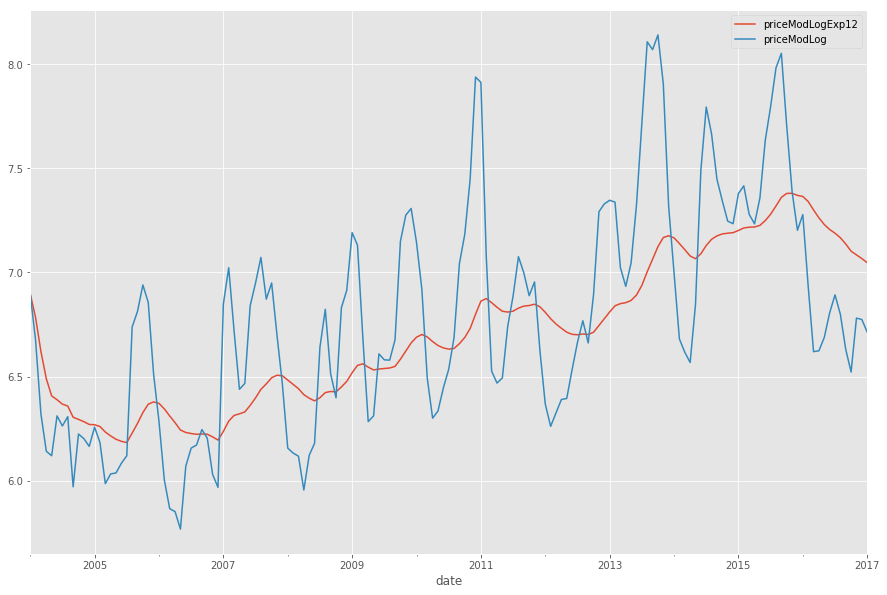

In [138]:
dfBang.plot(kind ="line", y=["priceModLogExp12", "priceModLog"])

In [139]:
dfBang["priceExp12"] = np.exp(dfBang.priceModLogExp12)
dfBang.tail()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1,priceModLogDiff,priceRandom,priceModLogMA12,priceMA12,priceModLogExp12,priceExp12
date,,,,,,,,,,,,,,,
2016-09,831895,758,2016-09-01,6.630683,879.77008,152,1507.162884,1547.580604,6.799056,-0.168372,897.0,6.963962,1057.816629,7.136718,1257.295268
2016-10,1620273,680,2016-10-01,6.522093,879.77008,153,1518.166935,1718.113199,6.630683,-0.108591,758.0,6.865553,958.675559,7.102217,1214.657091
2016-11,1974018,881,2016-11-01,6.781058,879.77008,154,1529.251328,1780.255979,6.522093,0.258965,680.0,6.814895,911.321125,7.084189,1192.955904
2016-12,947081,875,2016-12-01,6.774224,879.77008,155,1540.416650,1608.375119,6.781058,-0.006834,881.0,6.779192,879.358112,7.066790,1172.379009
2017-01,363991,824,2017-01-01,6.714171,879.77008,156,1551.663492,1406.449037,6.774224,-0.060053,875.0,6.732212,839.000711,7.046997,1149.401897


In [140]:
# Root Mean Squared Error (RMSE)
model_Exp12_RMSE = RMSE(dfBang.priceExp12, dfBang.priceMod)
model_Exp12_RMSE

543.60470695979075

In [141]:
y_exp = dfBang.priceModLog[-1]
y_exp

6.7141705299094721

In [142]:
y_for = dfBang.priceModLogExp12[-1]
y_for

7.0469969967290496

In [143]:
model_Exp12_forecast = alpha * y_exp + (1 - alpha) * y_for

In [144]:
dfBangResults.loc[4,"Model"] = "Exp Smoothing 12"
dfBangResults.loc[4,"Forecast"] = np.exp(model_Exp12_forecast)
dfBangResults.loc[4,"RMSE"] = model_Exp12_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,879.77,661.04
1,Linear,1442.79,564.998
2,Random,875,314.319
3,Moving Average 12,839.001,518.021
4,Exp Smoothing 12,1128.13,543.605


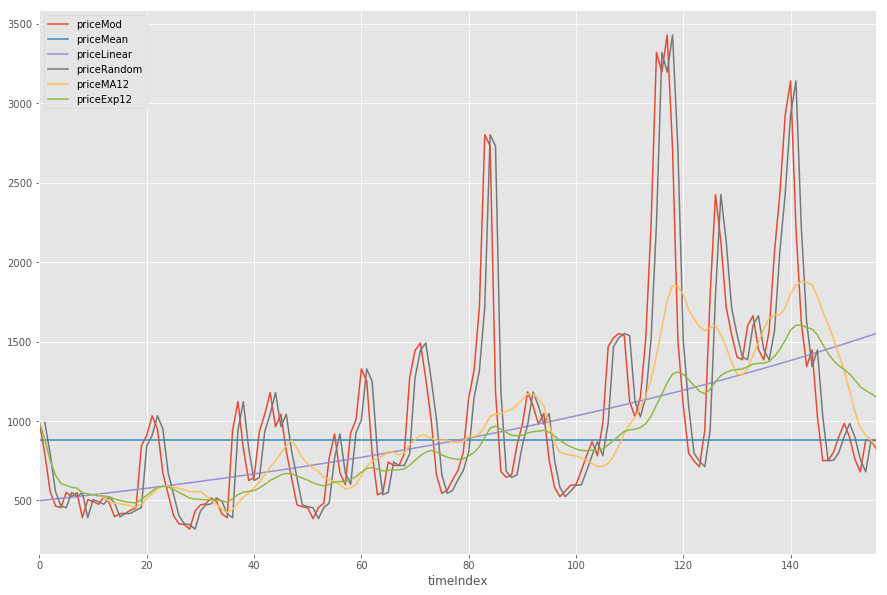

In [145]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", 
                                             "priceRandom",
                                             "priceMA12", "priceExp12"])

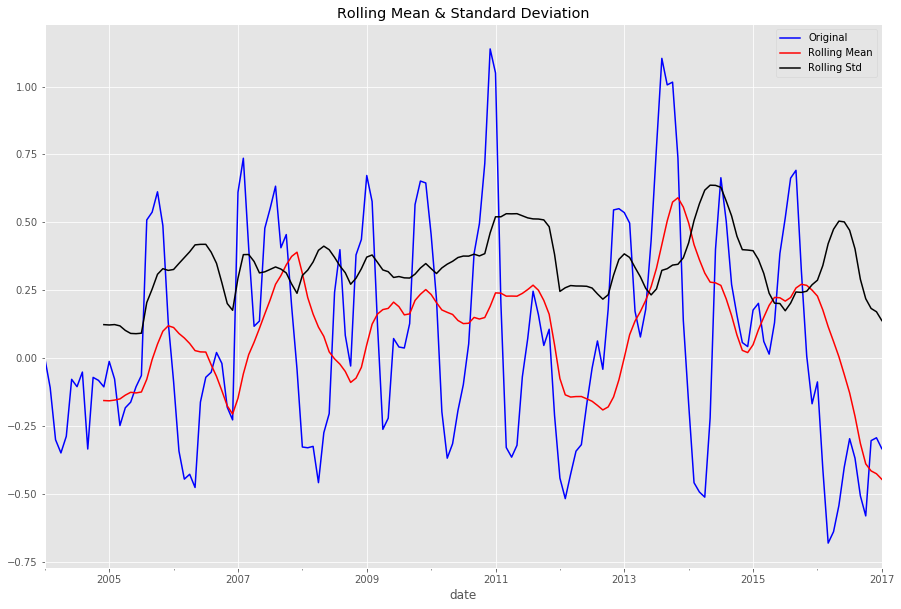

Test Statistic                -6.372809e+00
p-value                        2.322576e-08
# of Lags Used                 1.000000e+00
Number of Observations Used    1.550000e+02
Critical Value (10%)          -2.576812e+00
Critical Value (5%)           -2.880374e+00
Critical Value (1%)           -3.473259e+00
dtype: float64

In [146]:
# Test remaining part for Stationary
ts = dfBang.priceModLog - dfBang.priceModLogExp12
ts.dropna(inplace = True)
adf(ts)

## Eliminating Trend and Seasonality

- Differencing – taking the differece with a particular time lag
- Decomposition – modeling both trend and seasonality and removing them from the model.

## Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. We have already done first order difference earlier

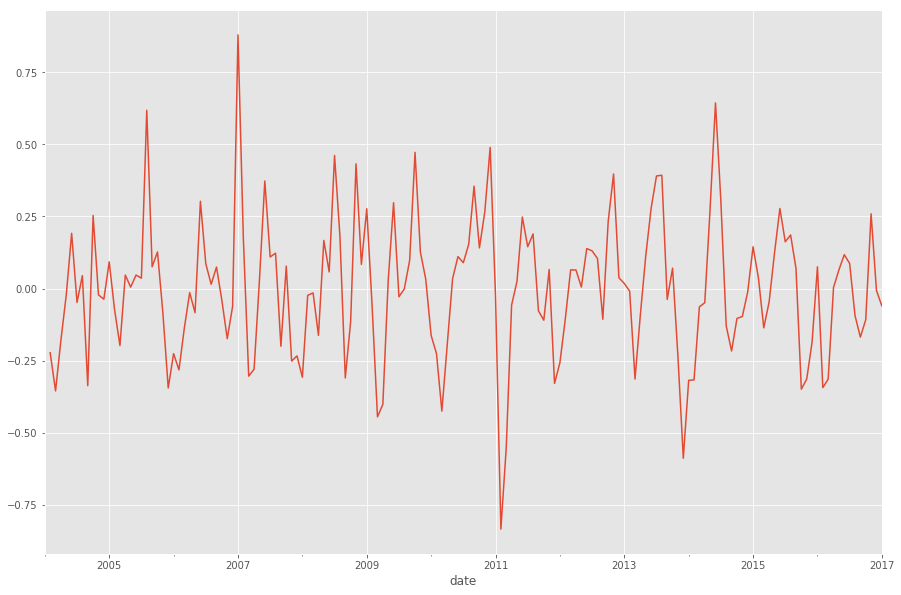

In [147]:
dfBang.priceModLogDiff.plot()

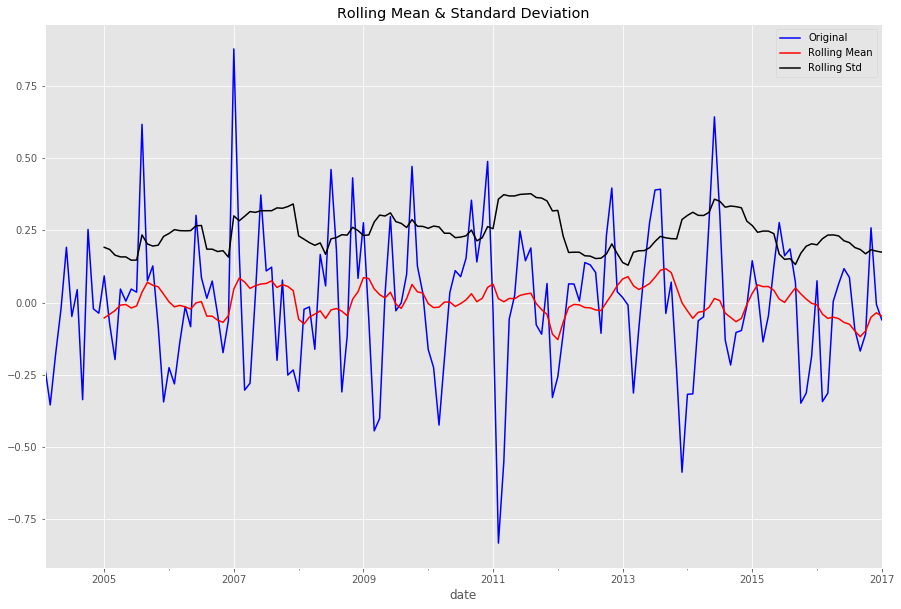

Test Statistic                -7.408867e+00
p-value                        7.222572e-11
# of Lags Used                 7.000000e+00
Number of Observations Used    1.480000e+02
Critical Value (10%)          -2.577293e+00
Critical Value (5%)           -2.881275e+00
Critical Value (1%)           -3.475325e+00
dtype: float64

In [148]:
# Test remaining part for Stationary
ts = dfBang.priceModLogDiff
ts.dropna(inplace = True)
adf(ts)

## Time Series Decomposition

We can also decompose the time series into trend and seasonality

In [149]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [150]:
dfBang.index = dfBang.index.to_datetime()

/Users/amitkaps/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: to_datetime is deprecated. Use self.to_timestamp(...)
  if __name__ == '__main__':


In [151]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1,priceModLogDiff,priceRandom,priceModLogMA12,priceMA12,priceModLogExp12,priceExp12
date,,,,,,,,,,,,,,,
2004-01-01,227832,991,2004-01-01,6.898715,879.77008,0,498.816527,477.253620,NaN,NaN,NaN,NaN,NaN,6.898715,991.000000
2004-02-01,225133,793,2004-02-01,6.675823,879.77008,1,502.458471,479.518099,6.898715,-0.222891,991.0,NaN,NaN,6.784051,883.641198
2004-03-01,221952,556,2004-03-01,6.320768,879.77008,2,506.127005,481.629448,6.675823,-0.355055,793.0,NaN,NaN,6.620623,750.412129
2004-04-01,185150,465,2004-04-01,6.142037,879.77008,3,509.822324,472.008583,6.320768,-0.178731,556.0,NaN,NaN,6.490419,658.799360
2004-05-01,137390,455,2004-05-01,6.120297,879.77008,4,513.544622,454.684748,6.142037,-0.021740,465.0,NaN,NaN,6.407606,606.440185


In [152]:
decomposition = seasonal_decompose(dfBang.priceModLog, model = "additive")

/Users/amitkaps/miniconda3/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


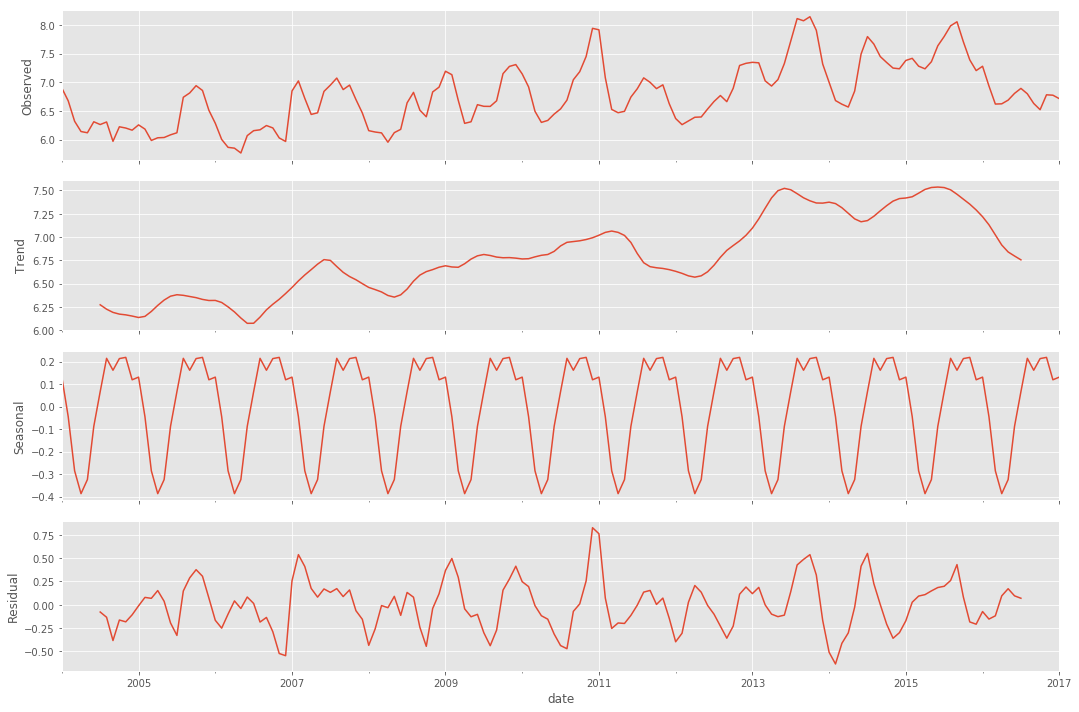

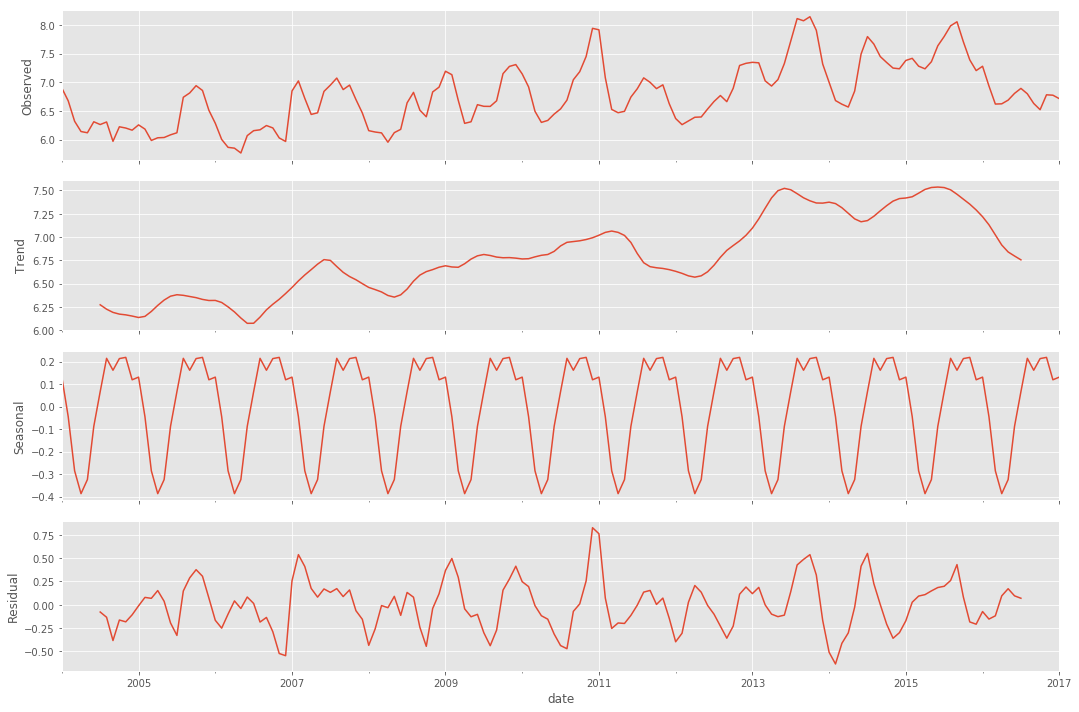

In [153]:
decomposition.plot()

In [154]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [155]:
dfBang["priceDecomp"] = np.exp(trend + seasonal)

In [156]:
# Root Mean Squared Error (RMSE)
model_Decomp_RMSE = RMSE(dfBang.priceDecomp, dfBang.priceMod)
model_Decomp_RMSE

373.02837911072373

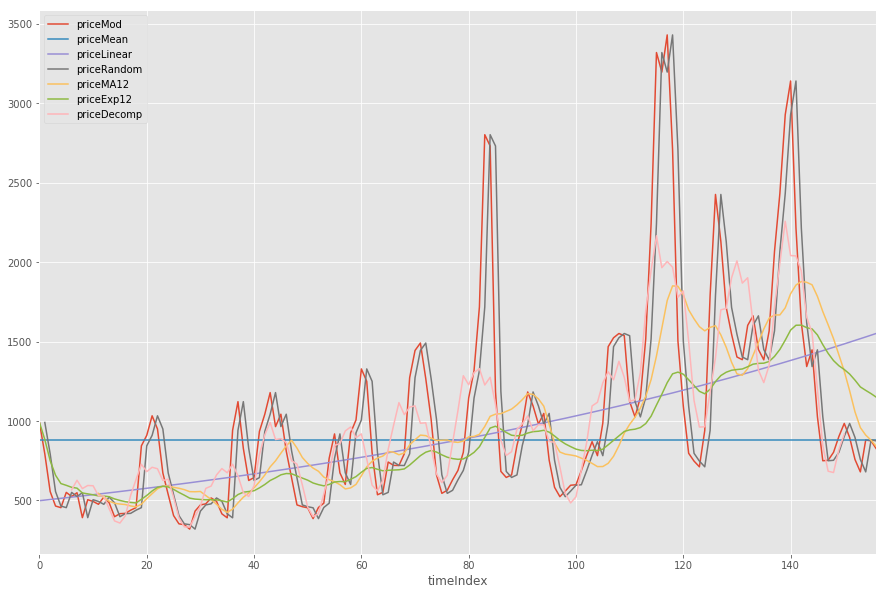

In [157]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom",
                                             "priceMA12", "priceExp12", "priceDecomp"])

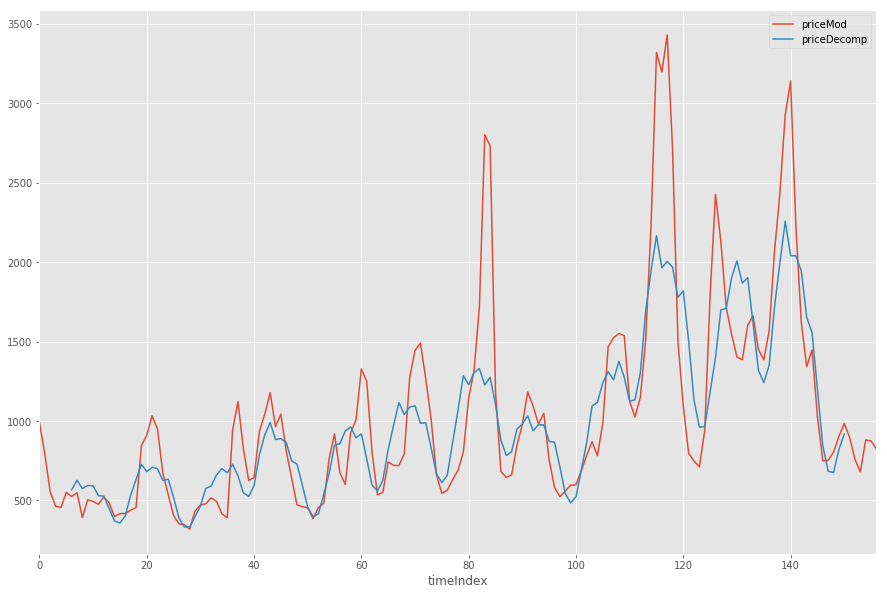

In [158]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod",
                                              "priceDecomp"])

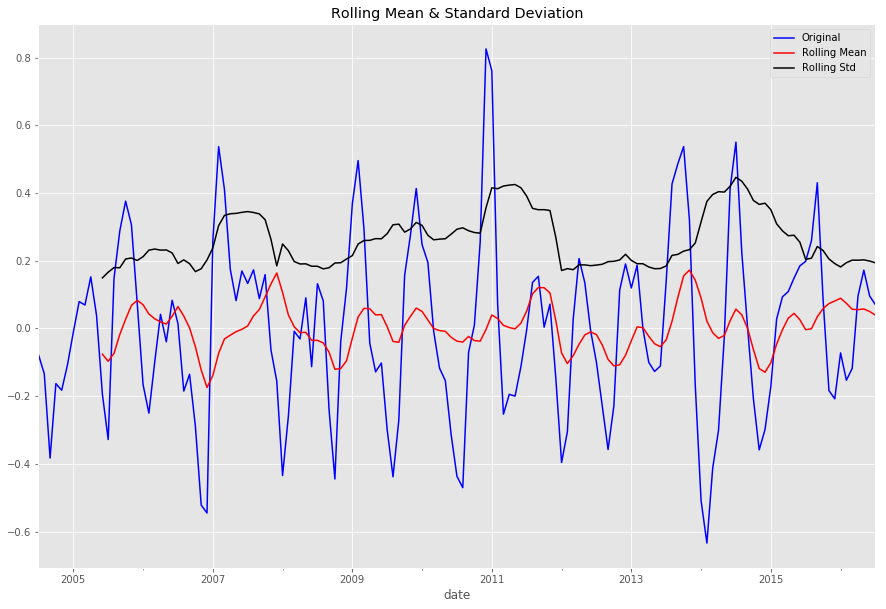

Test Statistic                  -4.706063
p-value                          0.000082
# of Lags Used                  12.000000
Number of Observations Used    132.000000
Critical Value (10%)            -2.578586
Critical Value (5%)             -2.883697
Critical Value (1%)             -3.480888
dtype: float64

In [159]:
# Test remaining part for Stationary
ts = decomposition.resid
ts.dropna(inplace = True)
adf(ts)

## Auto Regressive Models - AR(p)

In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself.

Thus an autoregressive model of order (p) can be written as

$$ y_t = c + m_1y_{t-1} + m_2y_{t-2} + m_3y_{t-3} + .. \\$$

**Random walk model is an AR(1) model with ** $$m_1=1,  c = 0\\$$
**Random walk model with drift model ** $$m_1=1,  c \not= 0\\$$

We normally restrict autoregressive models to stationary data, and then some constraints on the values of the parameters are required.

For an AR(1) model:   $$ −1<m_1<−1 \\$$
For an AR(2) model:   
$$ −1<m_2<−1, m_1 + m_2 < 1, m_2 - m_1 <1 \\$$

## Moving Average Model - MA(q)

Rather than use past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model.

$$ y_t=c+e_t+l_1 e_{t−1}+l_2 e_{t−2} + ... + l_q e_{t-q} \\$$

where `e` is white noise. We refer to this as an MA(`q`) model. Of course, we do not observe the values of e(t), so it is not really regression in the usual sense.

Notice that each value of `y(t)` can be thought of as a weighted moving average of the past few forecast errors. However, moving average models should not be confused with moving average smoothing. A moving average model is used for forecasting future values while moving average smoothing is used for estimating the trend-cycle of past values.

## ARIMA Model

If we combine differencing with autoregression and a moving average model, we obtain a non-seasonal ARIMA model. ARIMA is an acronym for AutoRegressive Integrated Moving Average model (“integration” in this context is the reverse of differencing). The full model can be written as

- **Number of AR (Auto-Regressive) terms (p)**: AR terms are just lags of dependent variable. For instance if p is 5, the predictors for y(t) will be y(t-1)….y(t-5).
- **Number of MA (Moving Average) terms (q)**: MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for y(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
- **Number of Differences (d)**: These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

- **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
- **Partial Autocorrelation Function (PACF)**: This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.


In MA model, noise / shock quickly vanishes with time. The AR model has a much lasting effect of the shock.

In [160]:
ts = dfBang.priceModLog
ts_diff = dfBang.priceModLogDiff
ts_diff.dropna(inplace = True)

In [161]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [162]:
lag_acf = acf(ts_diff, nlags=20)

In [163]:
lag_acf

array([  1.00000000e+00,   4.02282661e-01,  -3.85029189e-02,
        -2.11084696e-01,  -2.22356733e-01,  -2.40834240e-01,
        -2.10661228e-01,  -9.01674519e-02,  -9.22005747e-02,
        -6.85085979e-04,   1.36345360e-01,   2.17127409e-01,
         1.55448995e-01,   7.22485930e-03,  -2.12187923e-02,
        -6.99459739e-02,  -1.70696931e-01,  -7.71730621e-02,
        -3.30335057e-02,  -8.93429815e-02,  -2.08930298e-01])

In [104]:
ACF = pd.Series(lag_acf)

In [105]:
ACF

0     1.000000
1     0.402154
2    -0.028553
3    -0.214727
4    -0.237560
5    -0.263326
6    -0.220384
7    -0.085770
8    -0.075440
9     0.014978
10    0.123618
11    0.208630
12    0.158123
13    0.020539
14   -0.012909
15   -0.070976
16   -0.179937
17   -0.095146
18   -0.048783
19   -0.088541
20   -0.188109
dtype: float64

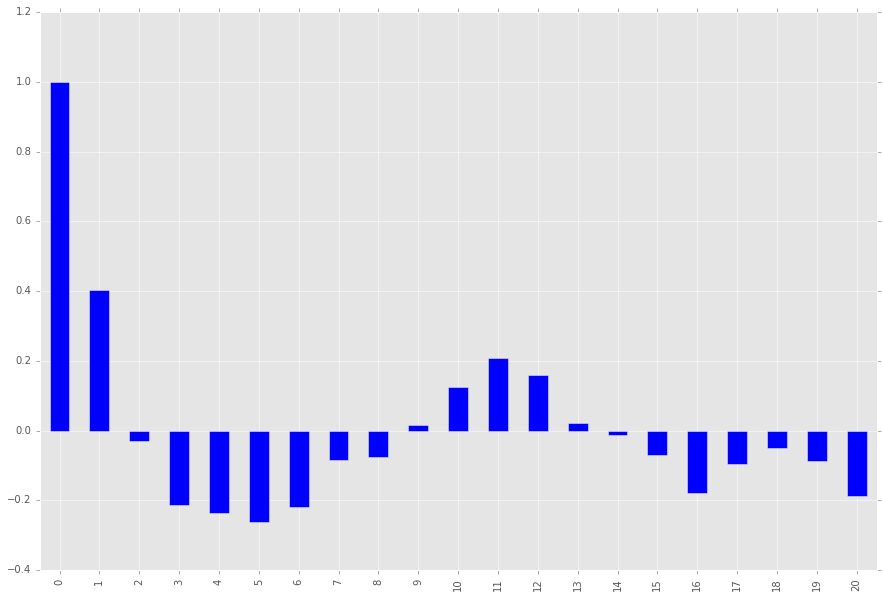

In [106]:
ACF.plot(kind = "bar")

In [107]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

In [108]:
PACF = pd.Series(lag_pacf)

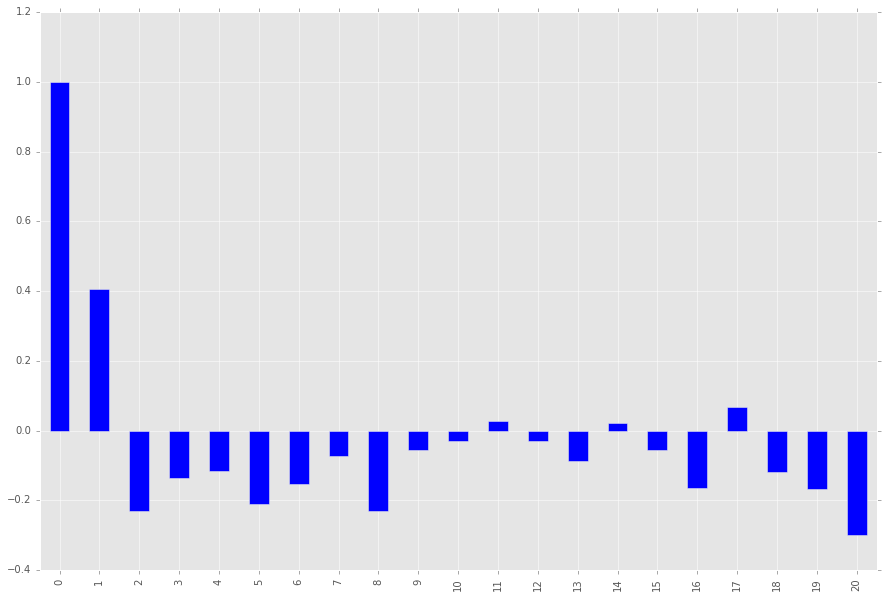

In [109]:
PACF.plot(kind = "bar")

### Running the ARIMA Model 

In [110]:
from statsmodels.tsa.arima_model import ARIMA

In [111]:
ts_diff.head()

2004-02-01   -0.222891
2004-03-01   -0.355055
2004-04-01   -0.178731
2004-05-01   -0.021740
2004-06-01    0.191437
Freq: MS, Name: priceModLogDiff, dtype: float64

In [112]:
# Running the ARIMA Model(1,0,1)
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))

In [113]:
results_ARIMA = model_AR1MA.fit(disp = -1)

In [114]:
results_ARIMA.fittedvalues.head()

2004-02-01   -0.000977
2004-03-01   -0.093805
2004-04-01   -0.139355
2004-05-01   -0.041727
2004-06-01    0.002164
Freq: MS, dtype: float64

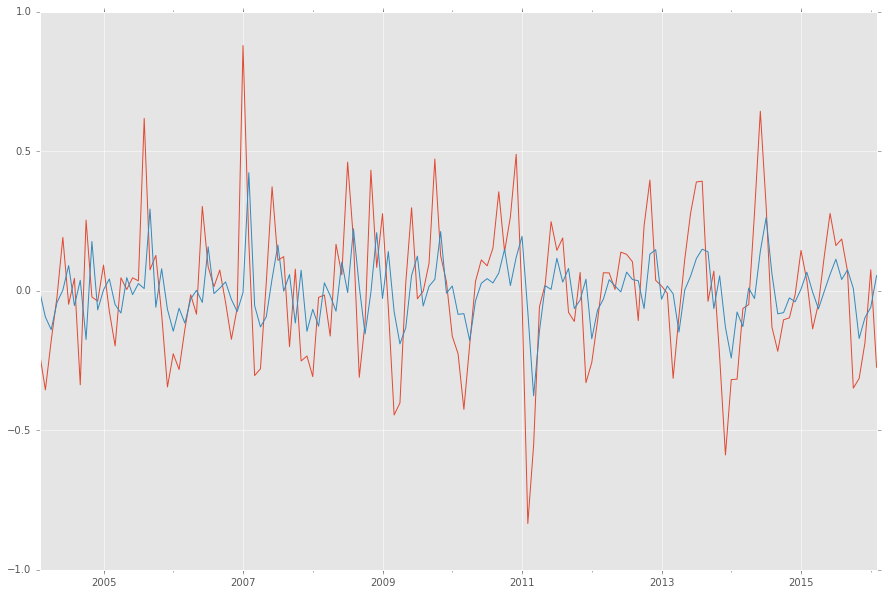

In [115]:
ts_diff.plot()
results_ARIMA.fittedvalues.plot()

In [116]:
ts_diff.sum()

0.1052596023926915

In [117]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.tail()

2015-10-01    0.008537
2015-11-01   -0.170970
2015-12-01   -0.096505
2016-01-01   -0.059154
2016-02-01    0.054308
Freq: MS, dtype: float64

In [118]:
predictions_ARIMA_diff.sum()

0.07204872072412598

In [119]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.tail()

2015-10-01    0.344369
2015-11-01    0.173399
2015-12-01    0.076894
2016-01-01    0.017740
2016-02-01    0.072049
Freq: MS, dtype: float64

In [120]:
ts.ix[0]

6.8987145343299883

In [121]:
predictions_ARIMA_log = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.tail()

2015-10-01    7.243084
2015-11-01    7.072114
2015-12-01    6.975609
2016-01-01    6.916455
2016-02-01    6.970763
Freq: MS, dtype: float64

In [122]:
dfBang['priceARIMA'] = np.exp(predictions_ARIMA_log)

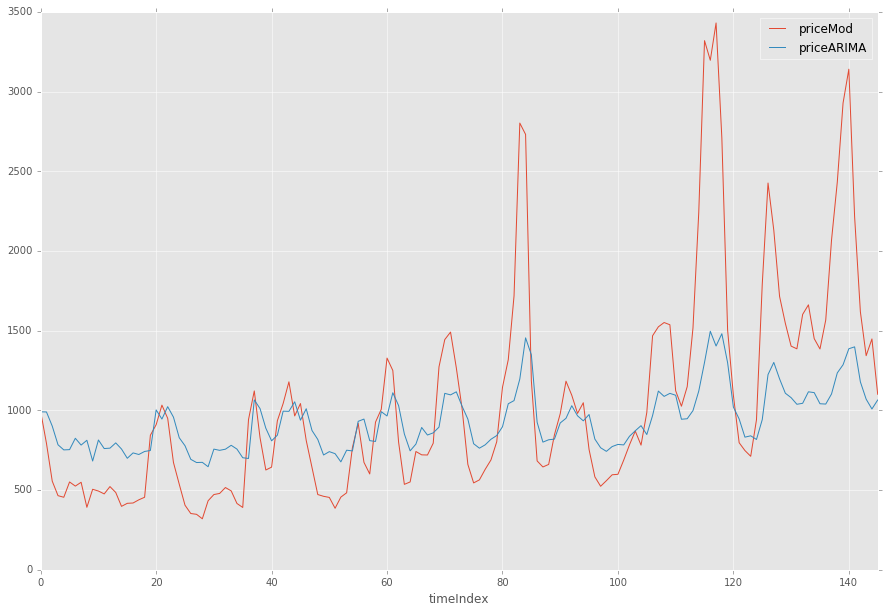

In [123]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceARIMA"])

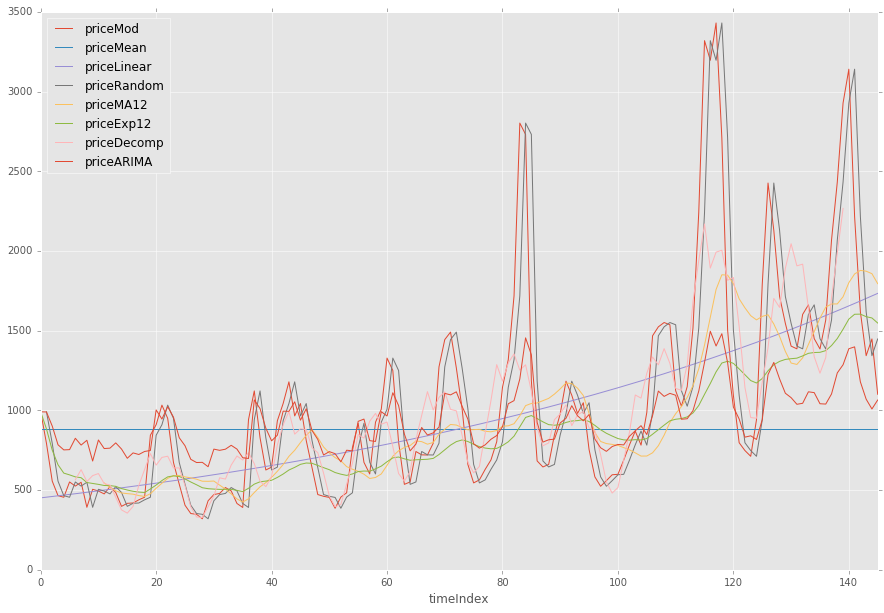

In [124]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom",
                                             "priceMA12", "priceExp12", "priceDecomp", "priceARIMA"])